In [255]:
from torch.utils.data import Dataset, DataLoader
import torch

import random
import jieba

class MyChineseBertDataset(Dataset):
    def __init__(self, corpus_path, vocab, seq_len, encoding='utf-8'):
        """
        创建数据集
        :param corpus_path: 数据集的路径，corpus的意思是语料库
        :param vocab: 词典
        :param seq_len: 指定的序列长度
        :param encoding: 编码方式，默认为utf-8
        """
        self.vocab = vocab
        self.seq_len = seq_len
        
        self.corpus_path = corpus_path
        self.encoding = encoding
        
        # 将数据集的每一行分割并存储到 self.lines中, 以'\t'分割，用于下面的__getitem__方法，以强化其在不同任务中的通用性
        with open(corpus_path, 'r', encoding=encoding) as f:
            self.lines = [line[:-1].split('\t') for line in f.readlines()]
            self.corpus_lines = len(self.lines)
            
    def __len__(self):
        return self.corpus_lines
        
    def __getitem__(self, item):
        # is_next_label: 1表示是下一句，0表示不是下一句
        t1, t2, is_next_label = self.random_sent(item)
        t1_random, t1_label = self.random_word(t1)
        t2_random, t2_label = self.random_word(t2)
        
        # 在t1_random和t2_random的首尾分别加上[CLS]和[SEP]标志
        t1 = [self.vocab.cls_index] + t1_random + [self.vocab.sep_index]
        t2 = t2_random + [self.vocab.sep_index]
        
        # 在句子的标签中加上[PAD]标志, 使得句子的长度都为seq_len
        t1_label = [self.vocab.pad_index] + t1_label + [self.vocab.pad_index] 
        t2_label = t2_label + [self.vocab.pad_index]
    
        # segment_label 是一个列表，用于指示句子中的每个词属于哪个句子, segment的意思是段落
        segment_label = ([0 for _ in range(len(t1))] + [1 for _ in range(len(t2))])[:self.seq_len]
        
        # 输入由两个句子组成, 将两个句子拼接在一起，并且截断到指定长度
        model_input = (t1+t2)[:self.seq_len]
        model_label = (t1_label+t2_label)[:self.seq_len]
        
        # 如果输入的长度小于指定长度，则用[PAD]标签来填充
        padding = [self.vocab.pad_index for _ in range(self.seq_len - len(model_label))]
        model_input.extend(padding), model_label.extend(padding), segment_label.extend(padding)
        
        # 将模型输入和标签转换回原始句子
        # original_t1 = self.vocab.from_seq(t1, join=True, with_pad=True)
        # original_t2 = self.vocab.from_seq(t2, join=True, with_pad=True)
        
        # 返回模型的输入和标签
        output = {
            'input': torch.tensor(model_input),
            'output': torch.tensor(model_label),
            'segment': torch.tensor(segment_label),
            'is_next': torch.tensor(is_next_label)
        }
        
        return {key: value.clone().detach() for key, value in output.items()}
        
        # 生成随机遮蔽的句子，返回遮蔽后的句子和标签
    def random_word(self, sentence):
        # 对中文token进行分割
        tokens = [char for char in sentence]
        output_label = []
        
        for i, token in enumerate(tokens):
            # 将15%的词进行替换
            prob = random.random()
            if prob < 0.15:
                prob /= 0.15
                
                # 80% 的概率进行替换为[MASK]
                if prob < 0.8:
                    tokens[i] = self.vocab.mask_index
                    
                # 10% 的概率进行替换为随机字, 增加模型的鲁棒性
                elif prob < 0.9:
                    tokens[i] = random.randrange(len(self.vocab))
                    
                # 10% 的概率不进行替换，也是为了增加鲁棒性
                else:
                    # stoi是string to index的缩写，如果没有找到这个字返回'<unk>'
                    tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)
                                            
                # 记录被替换的词, 用于计算loss
                output_label.append(self.vocab.stoi.get(token, 1))
                
            else:
                tokens[i] = self.vocab.stoi.get(token, self.vocab.unk_index)
                output_label.append(0)
                
        return tokens, output_label
    
    # 随机获取一对句子和一个标签
    def random_sent(self, index):
        t1, t2 = self.get_corpus_line(index)
        
        # 50%的概率获得连续的句子，标记标签1，这样做是为了提升在预测下一句任务上的能力
        if random.random() > 0.5:
            return t1, t2, 1
        else:
            return t1, self.get_random_line(), 0
        
    # 获取数据集的一行
    def get_corpus_line(self, item):
        return self.lines[item][0], self.lines[item][1]
    
    # 随机获取数据集的一行
    def get_random_line(self):
        return self.lines[random.randrange(self.corpus_lines)][0]

In [256]:
import pickle
from collections import Counter

import tqdm

class WordVocab:
    def __init__(self, texts, min_freq=1):
        print("正在构建Vocab词表")
        counter = Counter() # Counter可以接受迭代器，进行计数
        for line in tqdm.tqdm(texts):
            # # 检查line是不是一个列表， 用来判断是不是连续的（主要应该是处理英文单词的吧，我这里就不修改了，以后好搬用）
            # if isinstance(line, list):
            #     words = line
            # else:
            #     # 要处理中文词汇要去除' ' 
            #     words = list(line.replace('\n', '').replace('\t','').replace(' ',''))
            # 处理中文的方法
            words = [char for char in line]
            
            # 提取字并计数
            for word in words:
                counter[word] += 1
                
        self.freq = counter
        counter = counter.copy()
        
        # itos是index_to_string的缩写
        self.itos = ['[PAD]', '<unk>', '[CLS]', '[SEP]', '[MASK]']
        for token in self.itos:
            del counter[token]
            
        # 通过词频进行排序， counter.items()返回元组对，lambda无名函数用于获取次数
        words_and_freq = sorted(counter.items(), key=lambda tup: tup[0])
        # 然后按字母顺序进行排序
        words_and_freq.sort(key=lambda tup: tup[1], reverse=True)
        
        # 去除过少出现的字符
        for word, freq in words_and_freq:
            if freq < min_freq:
                break
            self.itos.append(word)
        
        self.stoi = {token: i for i, token in enumerate(self.itos)}
        
        self.unk_index = self.stoi['<unk>']
        self.cls_index = self.stoi['[CLS]']
        self.sep_index = self.stoi['[SEP]']
        self.mask_index = self.stoi['[MASK]']
        self.pad_index = self.stoi['[PAD]']
        
    def __len__(self):
        return len(self.itos)
    
    def to_seq(self, sentence, seq_len=None, with_len=False):
        # 由于处理的是中文，不能采用原本的分割方式，所以我改用了jieba的分割
        words = jieba.lcut(sentence)
            
        # 如果word在stoi中，就返回word中对应的数值，否则返回<unk>
        seq = [self.stoi.get(word, self.unk_index) for word in sentence]
        
        origin_seq_len = len(seq)
        
        if seq_len is None:
            pass
        elif len(seq) <= seq_len:
            # 如果不足长度就补0
            seq += [0 for _ in range(seq_len - len(seq))]
        else:
            seq = seq[:seq_len]
            
        return (seq, origin_seq_len) if with_len else seq
    
    def from_seq(self, seq, join=False, with_pad=False):
        # 将一个整数序列转换回词的序列，如果idx小于itos的长度,就返回itos[idx]，否则返回'<%d>'%d是idx的数值
        words = [self.itos[idx] if idx < len(self.itos) else '<%d>' % idx for idx in seq if not with_pad or idx != 0]
        return "".join(words) if join else words
    
    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, 'rb') as f:
            return pickle.load(f)
        
    def save_vocab(self, vocab_path):
        with open(vocab_path, 'wb') as f:
            pickle.dump(self, f)
        

In [257]:
# 读取数据集
import os
if os.path.exists('word_vocab.pkl'):
    vocab = WordVocab.load_vocab('word_vocab.pkl')
else:
    with open('../data/text_for_vocab.txt', 'r', encoding='utf-8') as f:
        texts = f.readlines()
    vocab = WordVocab(texts)
    vocab.save_vocab('word_vocab.pkl')

vocab_size = len(vocab)
print(vocab.itos[:50])
print(vocab_size)

['[PAD]', '<unk>', '[CLS]', '[SEP]', '[MASK]', '，', '。', '的', '了', '不', '一', '“', '是', '”', '人', '道', '来', '我', '这', '说', '：', '有', '你', '着', '个', '在', '他', '也', '去', '子', '里', '上', '们', '儿', '大', '那', '得', '玉', '出', '只', '宝', '又', '见', '就', '么', '好', '下', '到', '笑', '贾']
5209


In [258]:
# 测试读取数据集
from torch.utils.data import DataLoader

vocab = WordVocab.load_vocab('word_vocab.pkl')
dataset = MyChineseBertDataset('../data/qianbi.csv', vocab, 128)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

loader = next(iter(dataloader))
print(loader)

{'input': tensor([[   2, 2286, 1281,  405,  102,  592,  172,    5,  839,   53,    4,   23,
          133,  134,  136,   97,   15,    4,    4,  350,  452,    4,    4,  113,
           90,  523,    4,  254,    4,  230,  642,  460,   64,  338, 1037,    4,
            6,  295,  732,  532,    4,  913,  436,    1,    4,    3,  244,   83,
            4,  909,   91,  572,  141,   25,   60,   28,    7,  294,    4,  156,
           30,    4,    4,   12,  648,  470, 1433, 1179,    7,    4,    4,    5,
          171, 1149,  113,   71,  155,  271,    9, 1496, 1735,  154, 1079,  492,
          933,    6,  466,    4,   25,  111,  507,    4,   50,  557,  235,   14,
            7,   74,  173,  515,    5,  572,  141,    4,  426, 1659,  369,    5,
          267,   47,    8, 1398,  863,    4,  429,    6,    4,    4,    4,    4,
          141,  320, 1416,    5,   21,   10,   24,  307]]), 'output': tensor([[   0,    0,    0,    0,    0,    0,  172,    0,    0,    0,   61,    0,
            0,    0,    0,   

In [259]:
# from torch import nn
# 
# class MultiHeadedAttention(nn.Module):
#     def __init__(self, h, d_model, dropout=0.1):
#         # h表示number of heads， d_model表示hidden_layer_dimension
#         super().__init__()
#         # 确保每个头的维度都是整数不会出现尺寸不一致的情况
#         assert d_model % h == 0
# 
#         # 每个头的查询（Query）和键（Key）的维度
#         self.d_k = d_model // h
#         self.h = h
# 
#         self.multihead_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=h, dropout=dropout)
# 
#     def forward(self, query, key, value, mask=None):
#         # 默认情况下，PyTorch中的线性层的输入形状是 (batch_size, sequence_length, d_model)，但是在多头注意力中，我们通常希望将序列长度（sequence_length）作为第一个维度，
#         query, key, value = [x.permute(1,0,2) for x in (query,key,value)]
# 
#         attn_output, attn_weights = self.multihead_attn(query,key,value,attn_mask=mask)
#         return attn_output.permute(1,0,2)

In [260]:
import torch.nn as nn
import torch.nn.functional as F
import torch

import math

class Attention(nn.Module):

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

class MultiHeadedAttention(nn.Module):

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


In [261]:
# 测试MultiHeadAttention
import torch

# 定义输入
batch_size = 32
sequence_length = 10
d_model = 64
h = 8  # 注意力头的数量
dropout = 0.1

# 创建 MultiHeadedAttention 实例
attention_layer = MultiHeadedAttention(h, d_model, dropout)

# 生成随机输入
query = torch.randn((batch_size, sequence_length, d_model))
key = torch.randn((batch_size, sequence_length, d_model))
value = torch.randn((batch_size, sequence_length, d_model))

# 调用 forward 方法进行前向传播
output = attention_layer(query, key, value)

# 打印输出的形状
print("Output shape:", output.shape)

Output shape: torch.Size([32, 10, 64])


In [262]:
import torch.nn as nn
import torch.nn.functional as F

# 助于在编码器和解码器层中引入非线性特征映射，增加模型的表示能力。
class PositionwiseFeedForward(nn.Module):
    # d_ff:Feedforward 层的输出维度
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        
    # 新版torch加入了gelu，我们就不用再写gelu了
    def forward(self, x):
        return self.linear2(self.dropout(F.gelu(self.linear1(x))))

In [263]:
# 测试PositionwiseFeedForward
import torch

# 创建 PositionwiseFeedForward 模块
d_model = 64
d_ff = 128
dropout = 0.1
feed_forward = PositionwiseFeedForward(d_model, d_ff, dropout)

# 生成示例输入
batch_size = 32
sequence_length = 10
input_tensor = torch.randn(batch_size, sequence_length, d_model)

# 将输入传递给模块
output_tensor = feed_forward(input_tensor)

# 打印输出的形状
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)


Input shape: torch.Size([32, 10, 64])
Output shape: torch.Size([32, 10, 64])


In [264]:
# 残差连接（Residual Connection）和层归一化
# 通过堆叠多层网络，可以提高网络的表示能力，但也容易引入梯度消失或梯度爆炸等问题
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [265]:
import torch

# 创建一个小的输入张量
x = torch.rand((32, 10, 64))

# 创建 SublayerConnection 实例
size = 64  # 你的模型中的尺寸大小
dropout = 0.1  # 你的模型中的 dropout 率
sublayer_connection = SublayerConnection(size, dropout)

# 调用 forward 方法
output = sublayer_connection(x, lambda x: x * 2)  # 这里的 lambda 函数仅用于示例，你需要提供实际的 sublayer 函数

# 打印输出张量的形状
print("Input shape:", x.shape)
print("Output shape:", output.shape)


Input shape: torch.Size([32, 10, 64])
Output shape: torch.Size([32, 10, 64])


In [266]:
class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads,d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, x, mask):
        # 表示注意机制的 lambda 函数。注意机制应用于输入序列 _x 三次（查询、键和值相同），并且使用 mask 来屏蔽注意分数中的特定位置。
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [267]:
import torch

# 假设 hidden_size=256，attn_heads=8，feed_forward_hidden=1024，dropout=0.1
transformer_block = TransformerBlock(hidden=256, attn_heads=8, feed_forward_hidden=1024, dropout=0.1)

# 生成一个形状为 (batch_size, sequence_length, hidden_size) 的输入张量
input_tensor = torch.rand((32, 10, 256))

# 生成一个形状为 (batch_size, sequence_length, sequence_length) 的注意力遮蔽张量，例如屏蔽了对角线以下的元素
mask_tensor = torch.triu(torch.ones(10, 10)) == 1

# 调用 TransformerBlock 的 forward 方法
output_tensor = transformer_block(input_tensor, mask_tensor)

# 打印输出张量的形状
print("Output shape:", output_tensor.shape)


Output shape: torch.Size([32, 10, 256])


In [268]:
import torch.nn as nn
import torch
import math

class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()

        # 初始化位置编码矩阵，大小为 (max_len, d_model)
        pe = torch.zeros(max_len, d_model).float()
        pe.requires_grad = False  # 设置位置编码不需要梯度更新

        # 生成位置信息，表示为从 0 到 max_len-1 的浮点数，形状为 (max_len, 1)
        position = torch.arange(0, max_len).float().unsqueeze(1)

        # 计算位置编码的除数项，形状为 (d_model/2,)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        # 使用 sin 和 cos 函数计算位置编码矩阵中的值，分别作用于偶数和奇数列
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # 将位置编码矩阵添加一个维度，并注册为模型的缓冲区
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        输入 x 的形状为 (batch_size, sequence_length, d_model)，
        输出的位置编码将选择适当长度的部分返回。
        """
        return self.pe[:, :x.size(1)]


In [269]:
# 假设 input_tensor 是你的输入张量
d_model = input_tensor.size(-1)  # 获取输入张量的维度大小
max_len = 100
positional_embedding = PositionalEmbedding(d_model, max_len)

# 创建一个示例输入张量
batch_size = 32
sequence_length = 50
input_tensor = torch.randn(batch_size, sequence_length, d_model)

# 使用 PositionalEmbedding 进行前向传播
output_embedding = positional_embedding(input_tensor)

# 打印输出张量的形状
print("Input shape:", input_tensor.shape)
print("Output shape:", output_embedding.shape)


Input shape: torch.Size([32, 50, 256])
Output shape: torch.Size([1, 50, 256])


In [270]:
# 为输入的句子中的每个词生成对应的段（segment）嵌入（embedding）
class SegmentEmbedding(nn.Embedding):
    def __init__(self, embed_size=512):
        super().__init__(3, embed_size, padding_idx=0)

In [271]:
# 为输入的每个词生成对应的词嵌入（word embedding）。
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

In [272]:
class MyBERTEmbedding(nn.Module):
    def __init__(self, vocab_size, embed_size, dropout=0.1):
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size
        
    def forward(self, sequence, segment_label):
        x = self.token(sequence) + self.position(sequence) + self.segment(segment_label)
        return self.dropout(x)

In [273]:
import torch.nn as nn

class MyChineseBERT(nn.Module):

    def __init__(self, vocab_size, hidden=256, n_layers=12, attn_heads=8, dropout=0.1):

        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads

        self.feed_forward_hidden = hidden * 4

        self.embedding = MyBERTEmbedding(vocab_size=vocab_size, embed_size=hidden)

        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)])
        self.linear_next_sentence = nn.Linear(hidden, 2)
        self.linear_mask_lm = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, segment_info):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        x = self.embedding(x, segment_info)

        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)
        x1 = self.softmax(self.linear_next_sentence(x[:, 0]))
        x2 = self.softmax(self.linear_mask_lm(x))
        return x1, x2

In [274]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np

class MyBERTTrainer:
    def __init__(self, model, vocab, train_dataloader, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.vocab = vocab
        self.train_dataloader = train_dataloader
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)
        self.criterion = nn.CrossEntropyLoss()
        print("模型总参数量：", sum(p.numel() for p in model.parameters()))
        self.train_losses = []
        
    def train(self, epochs, dataloader):
        data_itr = tqdm.tqdm(enumerate(dataloader), desc="正在载入%d epoch的数据" % epochs, total=len(dataloader))
        
        loss = 0.0
        
        for i, data in data_itr:
            data = {key: value.to(self.device) for key, value in data.items()}
            
            next_sent_output, mask_lm_output = self.model.forward(data['input'], data['segment'])
            
            next_loss = self.criterion(next_sent_output, data['is_next'])
            
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data['output'])
            
            loss = next_loss + mask_loss
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            loss = loss.item()
            self.train_losses.append(loss)
            
            data_itr.set_postfix({'Epoch': epochs, 'Loss': loss})
            
        print("Epoch %d, Loss: %.4f" % (epochs, loss))
        
        return self.train_losses
    
    def plot_train_loss(self):
        plt.plot(np.arange(len(self.train_losses)), self.train_losses, label='Train Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
    def save_model(self, model_path):
        torch.save(self.model.state_dict(), model_path)
        

模型总参数量： 12150619


正在载入0 epoch的数据: 100%|██████████| 114/114 [03:25<00:00,  1.80s/it, Epoch=0, Loss=1.85]

Epoch 0, Loss: 1.8462


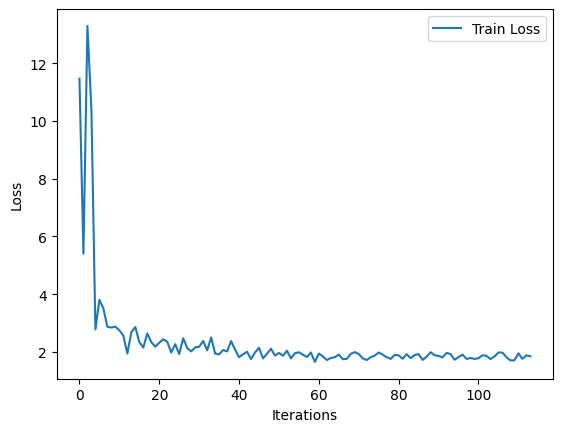

正在载入1 epoch的数据:  11%|█         | 12/114 [00:23<03:17,  1.93s/it, Epoch=1, Loss=1.91]


KeyboardInterrupt: 

In [275]:
if __name__ == '__main__':
    vocab = WordVocab.load_vocab('word_vocab.pkl')
    dataset = MyChineseBertDataset('../data/qianbi.csv', vocab, 128)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    model = MyChineseBERT(vocab_size=len(vocab), hidden=256)
    trainer = MyBERTTrainer(model, vocab, dataloader)
    
    for epoch in range(10):
        trainer.train(epoch, dataloader)
        if epoch % 5 == 0:
            trainer.plot_train_loss()
            trainer.save_model('save_model/my_chinese_bert_%d.pth' % epoch)